# SMA w/ Volatility

### Strategy Idea
- Use **20-day** and **50-day** moving averages.
- Go long when the 20-day SMA > 50-day SMA.
- Go short when the 20-day SMA < 50-day SMA.
- Only trade when the 14-day rolling volatility (std of returns) is below its historical median.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf

# Download SPY data
data = yf.download("SPY", start="2020-01-01", end="2025-01-01")
data = data[['Close']]
data.head()

/var/folders/yc/kqz385c915z5t31g92nb4wpr0000gn/T/ipykernel_12264/1386486859.py:7: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download("SPY", start="2020-01-01", end="2025-01-01")
[*********************100%***********************]  1 of 1 completed


Price,Close
Ticker,SPY
Date,
2020-01-02,298.578644
2020-01-03,296.317810
2020-01-06,297.448151
2020-01-07,296.611847
2020-01-08,298.192657


## Step 1: Compute Indicators
- 20-day and 50-day moving averages
- 14-day rolling volatility (standard deviation of returns)

In [2]:
# Moving averages
data['SMA20'] = data['Close'].rolling(window=20).mean()
data['SMA50'] = data['Close'].rolling(window=50).mean()

# Volatility (14-day rolling std of returns)
data['Volatility'] = data['Close'].pct_change().rolling(window=14).std()
vol_threshold = data['Volatility'].quantile(0.5)  # median volatility

data[['Close','SMA20','SMA50','Volatility']].tail()

Price,Close,SMA20,SMA50,Volatility
Ticker,SPY,,,
Date,,,,
2024-12-24,596.076904,594.363748,584.993627,0.010202
2024-12-26,596.116699,594.497818,585.459641,0.010197
2024-12-27,589.841614,594.408041,585.750360,0.010523
2024-12-30,583.110535,593.797943,585.905469,0.010831
2024-12-31,580.989136,593.028421,585.973887,0.010837


## Step 2: Generate Trading Signals
- Go **long** if SMA20 > SMA50 and volatility < threshold
- Go **short** if SMA20 < SMA50 and volatility < threshold
- Otherwise stay out of the market

In [3]:
data['Signal'] = 0
data.loc[(data['SMA20'] > data['SMA50']) & (data['Volatility'] < vol_threshold), 'Signal'] = 1
data.loc[(data['SMA20'] < data['SMA50']) & (data['Volatility'] < vol_threshold), 'Signal'] = -1
data[['Close','SMA20','SMA50','Volatility','Signal']].tail()

Price,Close,SMA20,SMA50,Volatility,Signal
Ticker,SPY,,,,
Date,,,,,
2024-12-24,596.076904,594.363748,584.993627,0.010202,0
2024-12-26,596.116699,594.497818,585.459641,0.010197,0
2024-12-27,589.841614,594.408041,585.750360,0.010523,0
2024-12-30,583.110535,593.797943,585.905469,0.010831,0
2024-12-31,580.989136,593.028421,585.973887,0.010837,0


## Step 3: Backtest Strategy
We compute daily returns and apply our trading signals.

In [4]:
data['Market Return'] = data['Close'].pct_change()
data['Strategy Return'] = data['Signal'].shift(1) * data['Market Return']

data['Cumulative Market'] = (1 + data['Market Return']).cumprod()
data['Cumulative Strategy'] = (1 + data['Strategy Return']).cumprod()
data.tail()

Price,Close,SMA20,SMA50,Volatility,Signal,Market Return,Strategy Return,Cumulative Market,Cumulative Strategy
Ticker,SPY,,,,,,,,
Date,,,,,,,,,
2024-12-24,596.076904,594.363748,584.993627,0.010202,0,0.011115,0.0,1.996382,1.38131
2024-12-26,596.116699,594.497818,585.459641,0.010197,0,0.000067,0.0,1.996515,1.38131
2024-12-27,589.841614,594.408041,585.750360,0.010523,0,-0.010527,-0.0,1.975498,1.38131
2024-12-30,583.110535,593.797943,585.905469,0.010831,0,-0.011412,-0.0,1.952955,1.38131
2024-12-31,580.989136,593.028421,585.973887,0.010837,0,-0.003638,-0.0,1.945850,1.38131


## Step 4: Plot Results

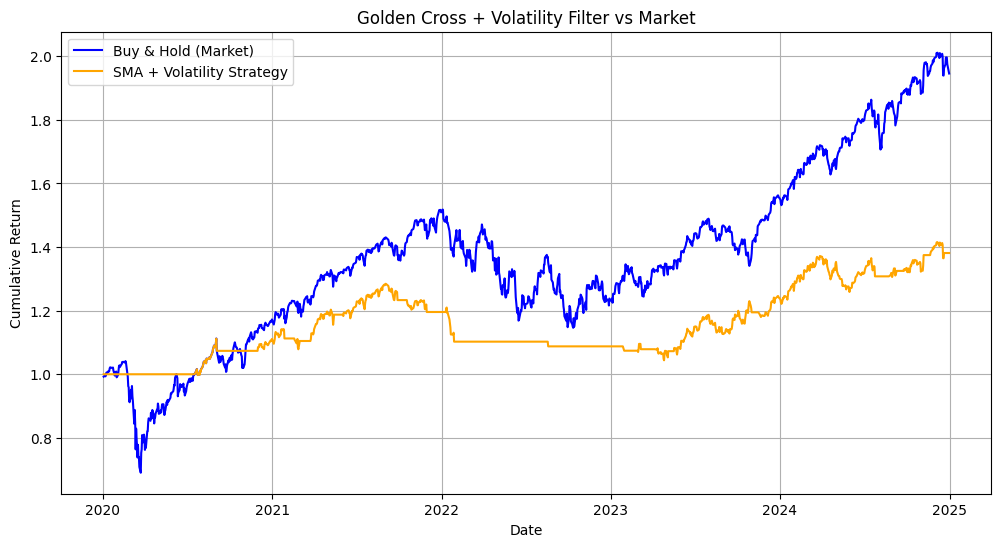

In [13]:
plt.figure(figsize=(12,6))
plt.plot(data['Cumulative Market'], label='Buy & Hold (Market)', color='blue')
plt.plot(data['Cumulative Strategy'], label='SMA + Volatility Strategy', color='orange')
plt.title("Golden Cross + Volatility Filter vs Market")
plt.xlabel("Date")
plt.ylabel("Cumulative Return")
plt.legend()
plt.grid(True)
plt.show()

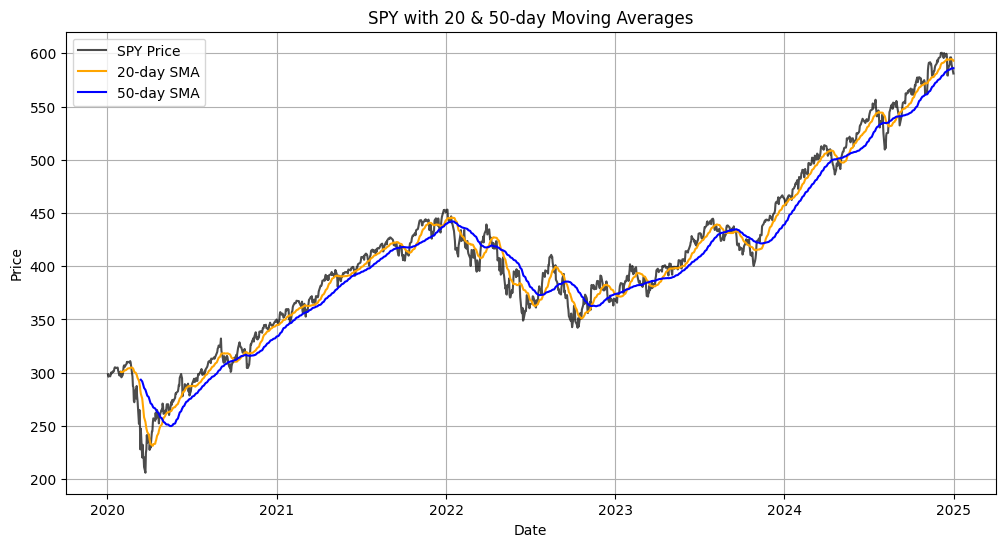

In [6]:
plt.figure(figsize=(12,6))
plt.plot(data['Close'], label='SPY Price', color='black', alpha=0.7)
plt.plot(data['SMA20'], label='20-day SMA', color='orange')
plt.plot(data['SMA50'], label='50-day SMA', color='blue')
plt.title("SPY with 20 & 50-day Moving Averages")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.grid(True)
plt.savefig("slide1_title.png", dpi=300, bbox_inches='tight')
plt.show()


In [14]:
# Starting capital
initial_investment = 100

# Strategy cumulative value
data['Strategy Value'] = initial_investment * (1 + data['Strategy Return']).cumprod()
strategy_final = data['Strategy Value'].iloc[-1]
strategy_pct_return = (strategy_final / initial_investment - 1) * 100

# Market cumulative value
data['Market Value'] = initial_investment * (1 + data['Market Return']).cumprod()
market_final = data['Market Value'].iloc[-1]
market_pct_return = (market_final / initial_investment - 1) * 100

# Sharpe Ratio (assuming 252 trading days/year and risk-free rate ~0)
strategy_sharpe = (data['Strategy Return'].mean() / data['Strategy Return'].std()) * np.sqrt(252)
market_sharpe = (data['Market Return'].mean() / data['Market Return'].std()) * np.sqrt(252)

# Print results
print("=== SMA + Volatility Strategy ===")
print(f"Final Value: ${strategy_final:.2f}")
print(f"Percent Return: {strategy_pct_return:.2f}%")
print(f"Annualized Sharpe Ratio: {strategy_sharpe:.2f}\n")

print("=== Buy & Hold (Market) ===")
print(f"Final Value: ${market_final:.2f}")
print(f"Percent Return: {market_pct_return:.2f}%")
print(f"Annualized Sharpe Ratio: {market_sharpe:.2f}")

=== SMA + Volatility Strategy ===
Final Value: $138.13
Percent Return: 38.13%
Annualized Sharpe Ratio: 0.80

=== Buy & Hold (Market) ===
Final Value: $194.58
Percent Return: 94.58%
Annualized Sharpe Ratio: 0.74
